The purpose of this notebook is to perform what was done earlier but then take the derivative of $\lambda$ wrt the inputs to get the PDF of $\lambda$. This should resemble the $\chi^2$ distribution.

In [180]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
from joblib import  Memory

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module
from model import RegularizedRegressionModel



try:
    import optuna
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
# import sympy as sy
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this

try:
    LFI_PIVOT_BASE = os.environ['LFI_PIVOT_BASE']
    print('BASE directoy properly set = ', LFI_PIVOT_BASE)
    utils_dir = os.path.join(LFI_PIVOT_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    # from utils import *                                                                                               
except Exception:
    print("""BASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/LFI_HEP


In [181]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)
DATA_DIR = os.path.join(LFI_PIVOT_BASE,'data')
memory = Memory(DATA_DIR)


In [182]:
def debug(func):
    """Print the function signature and return value"""
    import functools

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")
        return values

    return wrapper_debug

def theta_hat_func(n,m, MLE):
       #n,m are integer arrays
    if MLE==True:
        theta_hat = n-m
    else:
        # non-MLE
        # theta_hat = n-m
        # theta_hat = (theta_hat) * (theta_hat > 0)
        theta_hat = np.where(n>m, n-m, 0)
         
    return theta_hat

def L_prof_global(n,m, MLE):
    #n,m integer arrays
    # nu_hat = m, if theta_hat = theta_hat_MLE
    # nu_hat  =  (m+n)/2 if theta_hat = n-m
    # nu_hat = 0  if theta_hat != n-m
    theta_hat=theta_hat_func(n,m,MLE)
    # print('n-m ',  n-m)
    if MLE==True:
        # i.e. if theta_hat = n-m
        # assert theta_hat==n-m
        nu_hat = m
    else:
        nu_hat =(m+n)/2
        # if theta_hat== n-m:
        #     nu_hat = (m+n)/2
        # else:
        #     nu_hat = 0
        # nu_hat = np.where(theta_hat==n-m,
        #                   (m+n)/2, 
        #                   0)
            
        
    p1=st.poisson.pmf(n, theta_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2

def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2
def lambda_test_2d(n,m, theta, nu, MLE):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m, MLE)
    eps=1e-20
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [183]:
@memory.cache
def load_2d_train_df(MLE, with_lambda_D, small_df=False): 
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). 
    small_df: return a dataframe a fraction of the size"""
    # SUBSAMPLE=int(1e5)
    # if isinstance(df_name,str):
    if with_lambda_D==True:
        # USECOLS=['Z','theta', 'nu', 'lambda_D']
        USECOLS=['Z','theta', 'nu', 'lambda_D']
        if MLE==True:
            DF_NAME= 'TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_1000k_Examples_MLE_True.csv'
        else:
            DF_NAME='TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_30000k_Examples_MLE_False.csv'
            
    else:
        USECOLS=['theta', 'nu', 'N', 'M']
        DF_NAME='TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_30000k_Examples_MLE_False.csv'
        print('are you sure you want to use NM dataframe?')
    data_path=os.path.join(LFI_PIVOT_BASE, 
                    'data', DF_NAME)
        
    train_df = pd.read_csv(data_path, 
                    # nrows=SUBSAMPLE,
                    usecols=USECOLS
                )
    if small_df==True:
        sdf=train_df.iloc[:train_df.shape[0]//2]
        train_df=sdf
                              
    print(f'loading dataframe with name {DF_NAME}')
    print(train_df.describe())
    return train_df

In [184]:
eval_df = load_2d_train_df(MLE=False, with_lambda_D=True)
eval_df.head()

________________________________________________________________________________
[Memory] Calling __main__--home-ali-Desktop-Pulled_Github_Repositories-LFI_HEP-JupyterBook-<ipython-input-28f4bb6f5704>.load_2d_train_df...
load_2d_train_df(MLE=False, with_lambda_D=True)
loading dataframe with name TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_30000k_Examples_MLE_False.csv
                  Z         theta            nu      lambda_D
count  3.000000e+07  3.000000e+07  3.000000e+07  3.000000e+07
mean   9.697393e-01  9.998467e+00  9.999992e+00  2.494399e+01
std    1.713038e-01  5.774325e+00  5.773406e+00  1.753169e+01
min    0.000000e+00  2.072384e-07  1.013783e-06 -6.161996e+00
25%    1.000000e+00  4.997241e+00  4.999615e+00  1.109136e+01
50%    1.000000e+00  9.999364e+00  1.000065e+01  2.232372e+01
75%    1.000000e+00  1.499914e+01  1.500015e+01  3.592101e+01
max    1.000000e+00  2.000000e+01  2.000000e+01  2.693300e+02
________________________________________________load_2d_train_df - 51.3s, 0

,Z,theta,nu,lambda_D
0,1,10.976270,5.658606,5.009855
1,1,14.303787,19.321684,77.533441
2,1,12.055268,18.586260,65.413488
3,1,10.897664,6.853835,9.423238
4,1,8.473096,16.709449,29.487904


In [185]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

@memory.cache
def getwholedata_2d(MLE, with_lambda_D):
    """ Get train test split arrays"""
    
    data = load_2d_train_df(MLE=MLE, with_lambda_D=with_lambda_D)
        
    train_data, test_data = train_test_split(data, test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    # source = ['theta','nu','theta_hat','N','M']
    USECOLS=list(data.columns)
    USECOLS.pop(0)
    source = USECOLS

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.2)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

# step 1: Get trainig Data

In [187]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_2d(
    MLE=True,
    with_lambda_D=True)

________________________________________________________________________________
[Memory] Calling __main__--home-ali-Desktop-Pulled_Github_Repositories-LFI_HEP-JupyterBook-<ipython-input-246b6473de0a>.getwholedata_2d...
getwholedata_2d(MLE=True, with_lambda_D=True)
________________________________________________________________________________
[Memory] Calling __main__--home-ali-Desktop-Pulled_Github_Repositories-LFI_HEP-JupyterBook-<ipython-input-28f4bb6f5704>.load_2d_train_df...
load_2d_train_df(MLE=True, with_lambda_D=True)
loading dataframe with name TWO_PARAMETERS_WITH_LAMBDA_D_theta_0_20_1000k_Examples_MLE_True.csv
                    Z           theta              nu        lambda_D
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000
mean         0.961022       10.001202        9.999901       26.348822
std          0.193543        5.774584        5.775469       17.674733
min          0.000000        0.000033        0.000002        0.000057
25%          1.00000

In [188]:
N_FEATURES = train_x.shape[1]

In [189]:
class SiLURegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [190]:
@debug
def load_untrained_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

In [191]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a 
    dictionary of dictionaries"""
    models_path = os.path.join(LFI_PIVOT_BASE, 'models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with th string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    print(model)

In [192]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

# Step 2: define model parameters

In [193]:
PARAMS_lambdaD_nonMLE_SILU = {
"n_layers": int(6),
"hidden_size": int(6),
"dropout": float(0.13),
"NFEATURES":int(N_FEATURES),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*4),
'n_iterations': int(3e4),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_nonMLE_SILU.pth'
}

# step 3: load untrained model

In [194]:
untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

Calling load_untrained_model({'n_layers': 6, 'hidden_size': 6, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 1024, 'n_iterations': 30000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=6, out_features=6, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=6, out_features=6, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=6, out_features=6, bias=True)
    (13): Dropout

# Step 4: train untrained model

In [195]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)
def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, MLE, with_lambda_D):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    

    
    if MLE==True:
        train_t, train_x, test_t,  test_x, _, _ = getwholedata_2d(MLE=True, with_lambda_D=with_lambda_D)
    else:
        train_t, train_x, test_t,  test_x, _, _ = getwholedata_2d(MLE=False, with_lambda_D=with_lambda_D)
        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [196]:
BATCHSIZE=PARAMS_lambdaD_nonMLE_SILU["batch_size"]
traces_SiLU = ([], [], [], [])
traces_step = 2000
optimizer_name=PARAMS_lambdaD_nonMLE_SILU["optimizer_name"]

optimizer_SiLU = getattr(torch.optim, str(optimizer_name))(untrained_SiLU_model.parameters(), lr=PARAMS_lambdaD_nonMLE_SILU["starting_learning_rate"])

traces_SiLU = train(model=untrained_SiLU_model, 
              optimizer=optimizer_SiLU, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=PARAMS_lambdaD_nonMLE_SILU["n_iterations"], 
              traces=traces_SiLU, 
              step=traces_step, 
              window=200,
                MLE=False,
                with_lambda_D=True)

________________________________________________________________________________
[Memory] Calling __main__--home-ali-Desktop-Pulled_Github_Repositories-LFI_HEP-JupyterBook-<ipython-input-246b6473de0a>.getwholedata_2d...
getwholedata_2d(MLE=False, with_lambda_D=True)
train_t shape =  (24000000,) 

train_x shape =  (24000000, 3) 

_________________________________________________getwholedata_2d - 21.0s, 0.4min
Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.350313	  0.350326
     28000	  0.016431	  0.016399	  0.016399


# Step 4: Save trained model

In [197]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a dictionary of dictionaries"""
    models_path = os.path.join(LFI_PIVOT_BASE, 'models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with th string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    print(model)

In [198]:
save_model(model=untrained_SiLU_model,
           PARAMS=PARAMS_lambdaD_nonMLE_SILU,
           pth_string=PARAMS_lambdaD_nonMLE_SILU["pth_string"])

saving model with th string : FEB_20_model_lambda_D_nonMLE_SILU.pth

SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=6, out_features=6, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=6, out_features=6, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=6, out_features=6, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=6, out_features=6, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=6, out_features=1, bias=True)
    (19): Sigmoid()
  )
)


# Step 5: Load Trained model

In [199]:
def load_model(model, PARAMS, pth_string):
    models_path = os.path.join(LFI_PIVOT_BASE, 'models')
    PATH=os.path.join(models_path, pth_string)
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"]
    )
    checkpoint = torch.load(PATH)
    print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with th string : {pth_string}\n')    
    print(model)
    
    return model

In [200]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model = load_model(model = untrained_SiLU_model, 
                                PARAMS=PARAMS_lambdaD_nonMLE_SILU,
                   pth_string=PARAMS_lambdaD_nonMLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=6, out_features=6, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=6, out_features=6, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=6, out_features=6, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=6, out_features=6, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=6, out_features=1, bias=True)
    (19): Sigmoid()
  )
)
loading model with th string : FEB_20_model_lambda_D_nonMLE_SILU.pth

SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=6, b

In [221]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
        if (type(x) == type(1.0)) or (type(x) == type(1)):
            X = torch.Tensor(np.array([x]))
        else:
            X = torch.Tensor(np.array([x])).transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        return self.model(X).view(-1), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        # Y = dFdX.view(-1).detach().numpy()
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y  


In [222]:
def make_binned_X(X_min, X_max, Nbins):
    X_step = (X_max-X_min) / Nbins
    bins = np.arange(X_min, X_max+X_step, X_step)
    bin_centers = (bins[1:] + bins[:-1])/2
    return np.array(bin_centers)

def make_eval_data_2d_with_NM(Bprime, N, M, nbins_theta, nbins_nu):
    """Make evaluation data composed of: binned theta and nu, and discrete N and M,
    and optionally theta_hat. The theta hat argument accpts an MLE boolean, therefore
    if trained on MLE data, the theta_hat that we use for evaluation is just 
    n-m, including negative values.
    The return value of this function is used as the "eval_data" tensor below
    
    with lambda_D or with NM"""
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    train_df = load_2d_train_df(MLE=True, with_lambda_D=True)
    
    THETA_bin_centers = make_binned_X(X_min=train_df['theta'].min(),
                                      X_max=train_df['theta'].max(), 
                                      Nbins=nbins_theta)
        
    NU_bin_centers = make_binned_X(X_min=train_df['nu'].min(),
                                  X_max=train_df['nu'].max(), 
                                  Nbins=nbins_nu)
        
    # tensor = torch.Tensor([
                           # [x, y, theta_hat(N, M, MLE=True), N, M] 
                           # for (x,y) in zip(THETA_bin_centers,NU_bin_centers)
                          # ])

    tensor = torch.Tensor([
                       [x, y, theta_hat(N, M, MLE=True), N, M] 
                       for x in THETA_bin_centers for y in NU_bin_centers
                      ])

    #zip only traverses the lists monotonically, so experiment to use cross to take every combination of the two lists
    
    return tensor, THETA_bin_centers.ravel(), NU_bin_centers.ravel()

In [203]:
# eval_data_example, eval_bins_theta_example, eval_bins_nu_example =make_eval_data_2d_with_NM(
#                                                                                     Bprime=100, 
#                                                                                     N=1, 
#                                                                                     M=3, 
#                                                                                     nbins_theta=100,
#                                                                                     nbins_nu=100)

In [223]:
trained_SiLU_model.eval()

model_on_valid_x = trained_SiLU_model(torch.Tensor(valid_x))


In [224]:
model_on_valid_x_np=model_on_valid_x.view(-1).detach().numpy()
model_on_valid_x_np

array([1.        , 1.        , 1.        , ..., 0.99840397, 1.        ,
       1.        ], dtype=float32)

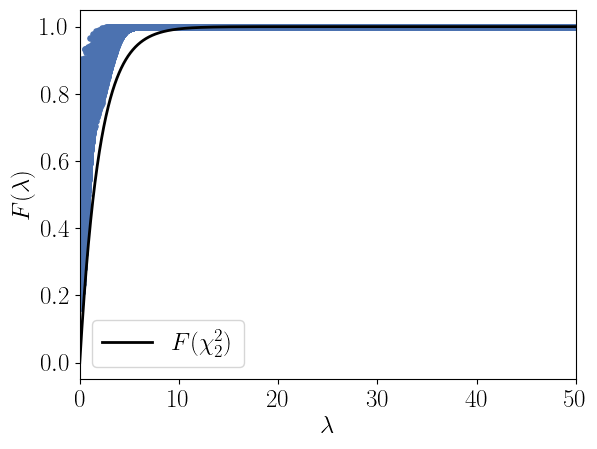

In [225]:
tmodel = TrainedModel(trained_SiLU_model)
cdf = tmodel.cdf(valid_x)

plt.scatter(valid_x[:,-1], 
            cdf,
            # model_on_valid_x_np, 
            s=14); 
x = np.linspace(0,200,20000)
plt.plot(x, st.chi2.cdf(x, 2), label=r'$F(\chi^2_2)$', color='black', linewidth=2 )
plt.xlim((0,50))
plt.ylabel(r'$F(\lambda)$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

Keep $\theta,\nu$ fixed, generate a bunch (4000) of experiments

In [ ]:
lambda_test_2d

In [213]:
chi2_exp_size=40000

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test_2d(theta=theta, nu=nu, n=n, m=m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_all(lambda_, theta, nu, ax_l):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 10
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax_l[0].set_xlim(x_range); ax_l[0].set_ylim(y_range)
    ax_l[0].set_xlabel(r'$\lambda_{NP} \left(\theta,\hat{\nu}(\theta) \mid n, m \right)$',fontsize=ftsize)
    ax_l[0].set_ylabel(r'cdf$(\lambda_{NP})$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    ax_l[0].hist(lambda_, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 2)
    ax_l[0].plot(x, y, color='blue',
    linewidth=2, label=r'CDF$(\chi^2_1)$')
    
    ax_l[1].set_ylabel(r'$p(\lambda_{NP})$', fontsize=ftsize)
    ax_l[1].hist(lambda_, bins=15, range=x_range,density=True,
    color=(0.8,0.8,0.9),
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.pdf(x, 2)
    ax_l[1].plot(x, y, color='blue',
    linewidth=2, label=r'$p(\chi^2_1)$')
    
    
    
    
    ax_l[2].set_ylabel(r'$p(\lambda_{NP})= \partial$', fontsize=ftsize)
    ax_l[2].hist(lambda_, bins=15, range=x_range,density=True,
    color=(0.8,0.8,0.9),
    histtype='stepfilled', edgecolor='black', 
                 # label=r'CDF$(\lambda)$'
                )
    tmodel = TrainedModel(trained_SiLU_model)
    X = np.empty((len(lambda_), 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    
    X[:,2] = np.linspace(0,10,len(lambda_))
    pdf = tmodel.pdf(X)
    
    ax[2].plot(X[:,2], pdf[:,0,-1])
    
    ############################################################
    
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax[0].text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax[0].legend(loc='upper right',fontsize=15)
    


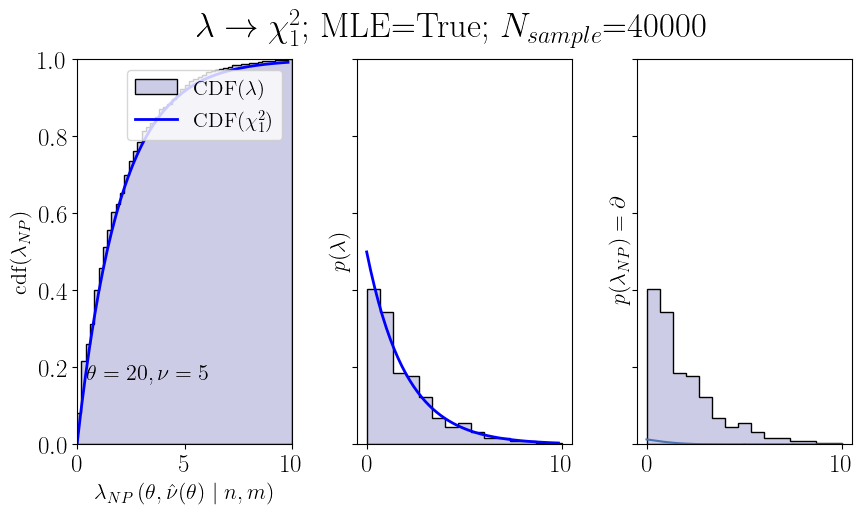

In [231]:
#points=(theta,nu)
points_1 = (20, 5)

MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

plt.subplots_adjust(wspace=0.3)
# plot_one(lambda_1, points_1[0], points_1[1], ax)
plot_all(lambda_1, points_1[0], points_1[1], ax)

fig.suptitle(r'$\lambda \rightarrow \chi^2_1$; MLE=%s; $N_{sample}$=%s' % \
             (  str(MLE), str(int(chi2_exp_size))), fontsize=25); 

ax[1].set_ylabel('$p(\lambda)$')

plt.show()
SAVE=False
if SAVE:
    plt.savefig('images/Wilk_agreement_MLE_%s_N_%s.png' % (str(MLE), str(chi2_exp_size) ))

In [227]:
tmodel = TrainedModel(trained_SiLU_model)
pdf = tmodel.pdf(valid_x)

In [229]:
pdf.shape

(160000, 1, 3)

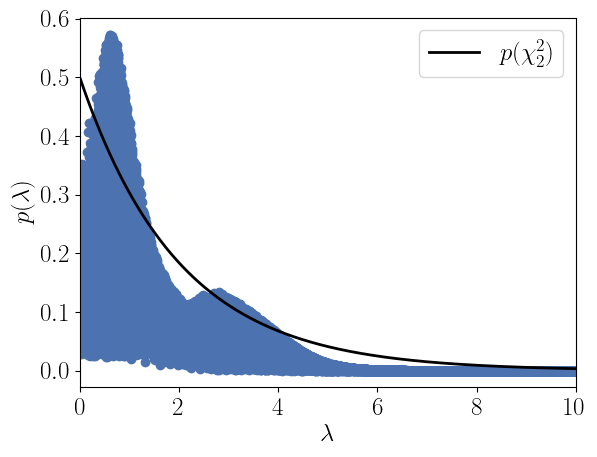

In [230]:
plt.scatter(valid_x[:,-1], pdf[:,0,-1])
plt.plot(x, st.chi2.pdf(x,2), label=r'$p(\chi^2_2)$', color='black', linewidth=2);
plt.xlabel(r'$\lambda$');plt.ylabel(r'$p(\lambda)$')
plt.xlim((0,10))
plt.legend()
plt.show()

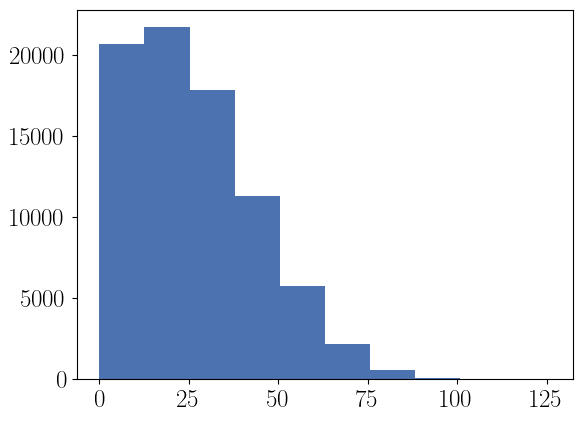

In [134]:
plt.hist(valid_x[:,-1]);plt.show()

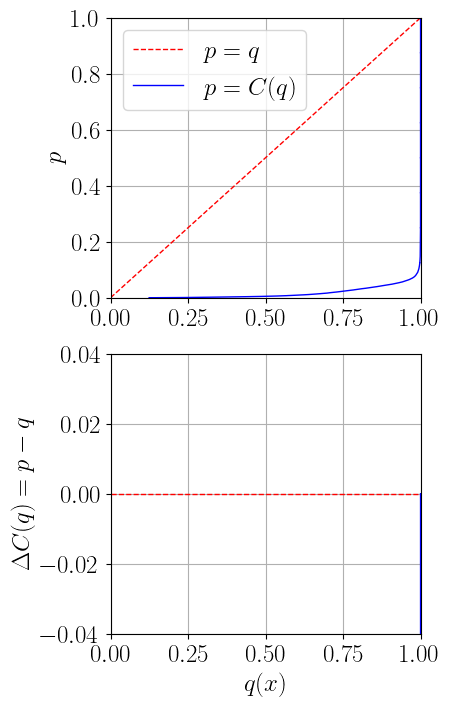

In [128]:
def plot_cc(q, p, ftsize=18):

    xmin, xmax = 0, 1
    ymin, ymax = 0, 1
    
    # create an empty figure
    fig = plt.figure(figsize=(4, 8))
    fig.tight_layout()
    
    # add subplots to it
    nrows, ncols = 2,1
    ax1 = fig.add_subplot(nrows, ncols, 1)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel('$p$', fontsize=ftsize)
    
    ax2 = fig.add_subplot(nrows, ncols, 2)
    dp  = 0.04
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-dp, dp)
    ax2.set_xlabel('$q(x)$', fontsize=ftsize)
    ax2.set_ylabel('$\Delta C(q) = p - q$', fontsize=ftsize)
    
    ax1.plot([0, 1], [0, 1], 'r', 
             linewidth=1, 
             linestyle='dashed', 
             label='$p = q$')
    ax1.plot(q, p, 'b', linewidth=1, 
             label='$p = C(q)$')
    ax1.grid(True, which="both", linestyle='-')
    ax1.legend()
    
    ax2.plot([0, 1], [0, 0], 'r', linewidth=1, linestyle='dashed')
    ax2.plot(q, p-q, 'b', linewidth=1)
    ax2.grid(True, which="both", linestyle='-')

    plt.show()

    
tmodel = TrainedModel(trained_SiLU_model)
a = tmodel.cdf(valid_x)

p = np.linspace(0,1,len(a))
q = np.quantile(a,p)
plot_cc(q, p)

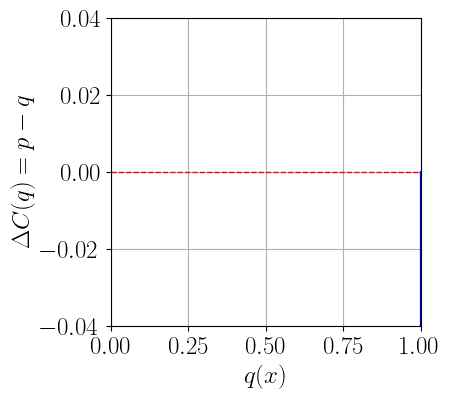

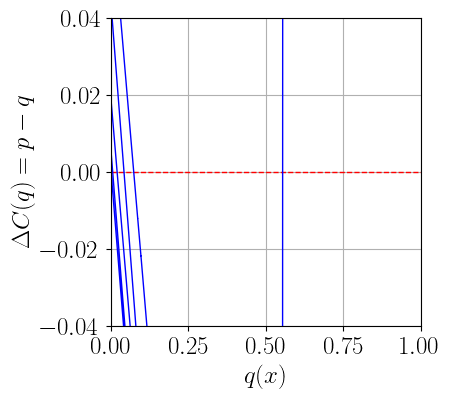

In [129]:
import scipy.optimize as op

def poly(X, A):
    y  = 0.0
    x  = np.array(X)
    for a in A:
        x *= X
        y += a * x
    return y

# 1st derivative of polynomials
def dpoly(X, A):
    y  = 0.0
    x  = np.ones(len(X))
    n  = 1
    for a in A:
        x *= X
        n += 1
        y += n * a * x
    return y

def plot_dc(q, p, res=None, ftsize=18):
    
    dp = 0.04
    xmin, xmax = 0, 1
    ymin, ymax =-dp, dp
    
    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add subplots to it
    nrows, ncols = 1,1
    ax = fig.add_subplot(nrows, ncols, 1)
    dp  = 0.04
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$q(x)$', fontsize=ftsize)
    ax.set_ylabel('$\Delta C(q) = p - q$', fontsize=ftsize)
    
    ax.plot([0, 1], [0, 0], 'r', linewidth=1, linestyle='dashed')
    ax.plot(q, p-q, 'b', linewidth=1, label='data')

    if res != None:
        y = poly(q, res.x)
        ax.plot(q, y,   'k', linewidth=1, label='fit')
    ax.grid(True, which="both", linestyle='-')

    plt.show()
    
    
    
def nll(pars, *args):
    x, y, w = args
    F = w*(y - poly(x, pars))**2
    return F.sum()

guess  = np.array([0.]*8)
results= op.minimize(nll, guess, args=(q, p-q, 1))

plot_dc(q, p, results)

# plot residuals of corrected cdf
Q = q + poly(q, results.x)
plot_dc(Q, p)